# [“Learning From Protein Structure with Geometric Vector Perceptrons”](https://openreview.net/pdf?id=1YLJDvSx6J4)
### A mini tutorial in applied Geometric Deep Learning.

We will be building a small model with an architecture similar to that of GVP, using the [MD17 dataset](https://arxiv.org/abs/2007.09593), which contains moleculewise energies ($\text{kcal}/\text{mole}$) and atomwise forces ($\text{kcal}/\text{mole}/\text{Angstrom}$).

To build a principled model, let‘s begin with the essential question in GDL: *what are the symmetries in our data?*

...

......

We would like our model’s energy prediction to be invariant to translation, rotation, and reflection (we say “invariant to $E(3)$”), and we would like its force predictions to be equivariant to the same (“equivariant to $E(3)$”). We would also like it to be equivariant to permutations of the nodes, since molecules do not come with canonical atom numberings.

The implementation of our model is a bit bulky for this presentation, so it is hidden, but you can verify via GitHub (if you really care) that each operation in this model is  by construction $E(3)$ and node-permutation equivariant.

We put our model through a brief training run and log its losses.

First, some imports.

In [6]:
import torch
from torch.nn import Module, Linear, SiLU, Embedding
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import global_add_pool
from utils import bessel_rbf, cosine_cutoff, make_v0
torch.set_default_dtype(torch.double)

# Mini PAINN
class MPAINNPrediction(Module):
    """PAINN (Polarizable Atomic Interaction Neural Network) as described in https://arxiv.org/pdf/2102.03150, except with embedding dimension 16 instead of 128.
    """
    def __init__(self):
        super().__init__()
        
        # activation function
        self.act = SiLU()

        # linear layers: 1 to update and 1 to consolidate
        self.linear_1 = Linear(16, 16)
        self.linear_2 = Linear(16, 1)
        
    def forward(self, x, data, pos):
        # prediction head takes in only invariant embeddings, which in this architecture are organized into last 1/4 of x tensor
        s = x[:, int(x.shape[1]*0.75):]
        
        # update embeddings
        s = self.linear_1(s)
        # nonlinearity
        s = self.act(s)
        # consolidate embeddings
        s = self.linear_2(s)
        
        # energy prediction is sum over node values
        E_hat = global_add_pool(s, data.batch)
        
        # force prediction is opposite gradient of energy with resepct to position
        F_hat = -torch.autograd.grad(E_hat.sum(), pos, retain_graph=True)[0]
        
        # return energy and force predictions
        return E_hat, F_hat

class MPAINNMessage(MessagePassing):
    """message block, as in Figure 2b of https://arxiv.org/pdf/2102.03150.
    """
    def __init__(self):
        super().__init__()
        
        # activation function
        self.act = SiLU()
        
        # `W• + b` layers of Figure 2b, proceeding top-to-bottom
        self.linear_1 = Linear(16,16)
        self.linear_2 = Linear(20,16*3)
        self.linear_3 = Linear(16,16*3)
        
    def forward(self, x, edge_index, edge_attr1, edge_attr2):
        # message passing to update x, embedding vector
        x = self.propagate(edge_index=edge_index, edge_attr1=edge_attr1, edge_attr2=edge_attr2, x=x)

        # return updated embedding
        return x
        
    def message(self, x_j, edge_index, edge_attr1, edge_attr2):
        # x is [(batch_size * num_nodes) x emb_dim x 4] tensor
        # v is [(batch_size * num_nodes) x emb_dim x 3] tensor, which is unrolled into a (batch_size * num_nodes) x (emb_dim * 3) tensor for storage in x
        # s is [(batch_size * sum_nodes) x emb_dim] tensor
        v_j = x_j[:,:int(x_j.shape[1] * 0.75)]
        s_j = x_j[:,int(x_j.shape[1] * 0.75):]
        
        # update s_j and expand it
        s_j = self.linear_1(s_j)
        s_j = self.act(s_j)
        s_j = self.linear_3(s_j)
        
        # edge_attr1 contains normalized edge vectors
        unit_edge_vec = edge_attr1
        # edge_attr2 contains magnitudes of edge vectors
        # unsqueeze so it plays nicely with bessel_rbf
        edge_vec_length = edge_attr2.unsqueeze(dim=1)
        
        # write edge vec lengths in bessel rbf under cosine cutoff
        edge_basis = bessel_rbf(x=edge_vec_length, n=20, r_cut=1.4415) * cosine_cutoff(x=edge_vec_length, r_cut=1.4415)
        # expand via linear layer
        edge_basis = self.linear_2(edge_basis)
        
        # elementwise multiply s_j and edge_basis to obtain tensor at `split` block in Figure 2b
        split = s_j * edge_basis
        # split this tensor into 3 equal parts
        even_third = int(split.shape[1]/3)
        split_1 = split[:, :even_third]
        split_2 = split[:, even_third:-even_third]
        split_3 = split[:, -even_third:]
        
        # elementwise multiply first 1/3 with equivariant embedding
        split_1 = split_1.view(-1,1,16)
        v_j = v_j.view(-1,3,16)
        v_j = split_1 * v_j
        
        # add last 1/3 to equivariant embedding
        # v_j += torch.einsum('ni,nj->nij', split_3, unit_edge_vec)
        
        # middle 1/3 is new invariant embedding
        s_j = split_2
        
        # concatenate v_j and s_j, which are residuals corresponding to node j, into a single tensor of dimension [batch_size x (emb_dim * 4)]
        out = torch.cat((v_j.view(v_j.size(0), -1), s_j), dim=1)
        
        # return message
        return out
        
    def update(self, aggr_out, x):
        # aggr_out contains sum of all messages
        # new embedding is found simply by adding message to previous embedding
        x += aggr_out
        
        # return new embedding
        return x

class MPAINNUpdate(MessagePassing):
    """update block, as in Figure 2c of https://arxiv.org/pdf/2102.03150.
    """
    def __init__(self):
        super().__init__()
        
        # activation function
        self.act = SiLU()
        
        # linear layers with bias are not equivariant
        self.U = Linear(16,16,bias=False)
        self.V = Linear(16,16,bias=False)
        
        # linear layers with bias for invariant embeddings
        self.linear_1 = Linear(16*2,16)
        self.linear_2 = Linear(16,16*3)
    
    def forward(self, x, edge_index):
        # message passing to update x, embedding vector
        x = self.propagate(edge_index=edge_index, x=x)
        
        # return updated embedding
        return x
        
    def message(self, x_j):
        # again: first 3/4 are unrolled equivariant embeddings, and last 1/4 is invariant embeddings
        v = x_j[:,:int(x_j.shape[1] * 0.75)]
        s = x_j[:,int(x_j.shape[1] * 0.75):]
        
        # change dimensions of v to allow it to be put through linear layer
        v = v.view(v.shape[0],3,16)
        v = self.U(v)
        
        # v_V is tensor in second column from left in Figure 2c
        v_V = self.V(v)
        v_V = v_V.view(v_V.shape[0],3,16)
        
        # stack_in is tensor in column 2.5 from left in Figure 2c, immediately after ||•||
        stack_in = torch.norm(v_V, dim=1)
        
        # concatenate stack_in and s
        stack = torch.cat((stack_in, s), dim=1)
        # s updated via linear layer
        s = self.linear_1(stack)
        # nonlinearity
        s = self.act(s)
        # put s through another linear layer to obtain tensor at `split` block in Figure 2c
        split = self.linear_2(s)
        
        # split this tensor into 3 equal parts
        even_third = int(split.shape[1]/3)
        split_1 = split[:,:even_third]    
        split_2 = split[:,even_third:-even_third]
        split_3 = split[:,-even_third:]
        
        # first 1/3 is multiplied by equivariant tensor, with each element in split_1 acting on corresponding 3-dimensional vector in v
        v = v.view(v.shape[0],3,16)
        v = split_1.unsqueeze(dim=1) * v
        
        # weird ensum thing for <•_1, •_2> when batch dimensions are in play
        # gives tensor [batch_dim x emb_dim]
        v_V = torch.norm(v * v_V, dim=1)
        # elementiwse multiply by split_2
        v_v = split_2 * v_V
        # add split_3
        v_V =  split_3 + v_V
        
        # reshape v for concatenation with v_V
        v = v.view(v.shape[0], -1)
        
        # v_V is s residual
        x = torch.cat((v, v_V), dim=1)
        
        # return residual
        return x
    
    def update(self, aggr_out, x):
        # aggr_out contains sum of all messages
        # new embedding is found simply by adding message to previous embedding, 
        # this is as far as I can tell: I believe Figure 2c is missing summations at bottom
        # otherwise I do not understand how v_j and s_j become \delta v_i^u and \delta s_i^u
        x += aggr_out
    
        # return new embedding
        return x

class MPAINNBlock(Module):
    """single message/update round, combining Figure 2b and Figure 2c in https://arxiv.org/pdf/2102.03150 for concision.
    """
    def __init__(self):
        super().__init__()
        
        # initialize constituent blocks
        self.message = MPAINNMessage()
        self.update = MPAINNUpdate()
    
    def forward(self, x, edge_index, edge_attr1, edge_attr2):
        # call message passing functions
        x = self.message(x, edge_index, edge_attr1, edge_attr2)
        x = self.update(x, edge_index)
        
        # return updated embedding
        return x

class Model(Module):
    def __init__(self):
        super().__init__()
        
        # embedding takes place outside all blocks
        self.embedding = Embedding(118,16)
        # 2 message/update rounds
        self.block_1 = MPAINNBlock()
        self.block_2 = MPAINNBlock()
        # s goes through prediction head to give atomwise energy predictions, which are summed to give energy prediction for whole system
        self.prediction = MPAINNPrediction()
        
    def forward(self, data):
        # get relevant parts from data
        edge_index = data.edge_index
        pos = data.pos.clone()
        pos = pos.double()
        # keep track of gradient of output wrt pos for force calculations
        pos.requires_grad_(True)
        
        # this cannot be done in preprocessing, otherwise force would not be able to be found as negative gradient of energy
        idx1, idx2 = edge_index
        edge_vec = pos[idx1] - pos[idx2]
        edge_vec_length = torch.norm(edge_vec, dim=1)
        unit_edge_vec = torch.div(edge_vec, edge_vec_length.unsqueeze(dim=1))
        
        # initialize equivariant features as 0 vector and invariant features via embedding block
        v = make_v0(data)
        s = self.embedding(data.z)
        
        # construct x by unrolling equivariant features and concatenating invariant features
        x = torch.cat((v.reshape(v.shape[0], -1), s), dim=1)
        
        # 2 message/update rounds
        x = self.block_1(x=x, edge_index=edge_index, edge_attr1=unit_edge_vec, edge_attr2=edge_vec_length)
        x = self.block_2(x=x, edge_index=edge_index, edge_attr1=unit_edge_vec, edge_attr2=edge_vec_length)
        
        # get predictions from prediction head
        F_hat, E_hat = self.prediction(x, data, pos)
        
        # return for loss calculation
        return F_hat, E_hat

In [27]:
def mini_train(model: MessagePassing, rho: float, num_items: int, batch_size: int, num_epochs: int) -> None:
    """trains model on dataloader, saves weights of the best-performing model, and logs ongoing results through wandb.
          
    parameters
    ----------
    model : MessagePassing
        self-explanatory.
    rho : float
        loss = (1-rho)*E_loss + rho*F_loss.
    num_epochs : int
        self-explanatory.
    batch_size : int
        self-explanatory.
    num_epochs: int
        self-explanatory.
    """
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.MSELoss()

    train_dataloader = get_mini_dataloader(molecule='benzene',
            num_items=num_items,
            batch_size=batch_size)

    losses = []
    # training loop occurs num_epochs times
    for _ in range(num_epochs):
        # track gradients
        model.train()
        
        # iterate through test_dataloader        
        for data in train_dataloader:
            
            # clear gradients
            optimizer.zero_grad()

            # target values
            E = data.energy
            F = data.force
            
            # predictions from the model
            E_hat, F_hat = model(data)
            E_hat.squeeze_(dim=1)

            # squared error for energy loss
            E_loss = loss_fn(E_hat, E)

            # a version of squared error for force loss
            F_loss = F_loss_fn(F_hat, F, loss_fn)
            
            # canonical loss
            loss = (1-rho)*E_loss + rho*F_loss
            
            # calculate gradients
            loss.backward()
            
            # keep track of losses
            losses.append(loss.item())
            
            # update
            optimizer.step()
            
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Batchwise Losses')
    plt.show()

In [29]:
import torch
from torch_geometric.datasets import MD17
# from MiniPAINN import Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from train import mini_train
from utils import get_mini_dataloader, get_molecule, get_random_roto_reflection_translation, E3_transform_molecule, E3_transform_force, plot_molecules, plot_molecules_with_forces, F_loss_fn
torch.set_default_dtype(torch.double)

torch.manual_seed(2002)

In [33]:
for t in ts:
    print(t.dtype)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64


Now, the training run.

In [32]:
model = Model()

mini_train(model=model,
      rho=0.99,
      num_items=512,
      batch_size=32,
      num_epochs=8)

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


E_hat.dtype: torch.float64
F_hat.dtype: torch.float64


RuntimeError: Found dtype Float but expected Double

It’s not very impressive that we get a good-looking loss plot. Our model has a lot of parameters and the dummy training set we’ve made is pretty small.

Much cooler is the assurance that our model behaves sensibly when we modify our data.

Let’s get a benzene molecule from the dataset.

In [ ]:
molecule = get_molecule(type='benzene')

Let’s check out this molecule’s atoms’ positions in space.

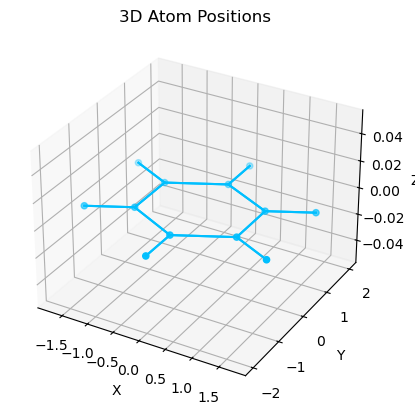

In [ ]:
plot_molecules(molecules=[molecule],
               colors=['deepskyblue'],
               labels=[''])

Next, let’s generate a random roto-reflection-translation. We rotate the molecule by a random rotation in 3-space, slide it in a random direction up to a distance of 1, and flip its orientation with probability 50%.

In [3]:
roto_reflection_translation = get_random_roto_reflection_translation()

Random roto-reflection:
	 0.595  0.598  0.536
	-0.784  0.289  0.549
	-0.174  0.748 -0.641
Random translation:
	   0.0
	   0.0
	   0.0


Let’s update our molecule’s atoms’ positions based on this roto-reflection-translation.

In [ ]:
transformed_molecule = E3_transform_molecule(molecule, roto_reflection_translation)

Let’s plot their positions in space compared to their original ones.

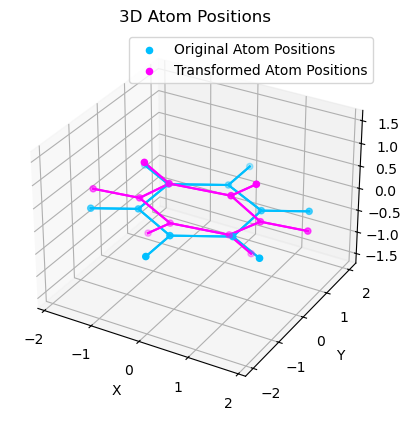

In [ ]:
plot_molecules(molecules=[molecule, transformed_molecule], 
               colors=['deepskyblue', 'magenta'], 
               labels=['Original Atom Positions', 'Transformed Atom Positions'])

This gives some assurance that we have, indeed, acted on our molecule, and that our action is in $E(3)$. We haven’t warped or sheared it, for example.

Let’s see how our model deals with our original and our transformed data.

In [ ]:
transformed_energy_prediction, transformed_force_predictions = model(transformed_molecule) # energy invariant
original_energy_prediction, original_force_predictions = model(molecule)

We must verify that the model’s energy prediction is invariant to $E(3)$.

In [ ]:
print(f'Predicted energy of the original molecule:    {original_energy_prediction.item(): 6.3f}.')
print(f'Predicted energy of the transformed molecule: {transformed_energy_prediction.item(): 6.3f}.')

Predicted energy of the original molecule:     0.345.
Predicted energy of the transformed molecule:  0.354.


Plotting the force predictions on each atom...

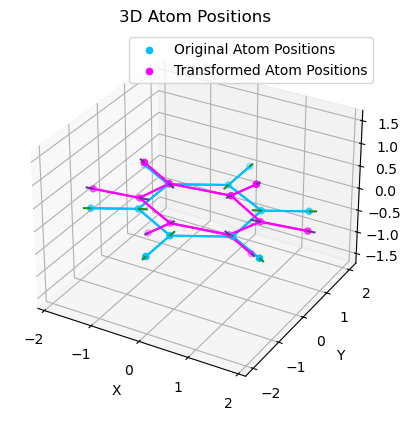

In [ ]:
plot_molecules_with_forces(molecules=[molecule, transformed_molecule],
                           forces=[original_force_predictions, transformed_force_predictions],
                           colors=[['deepskyblue','forestgreen'],['magenta','rebeccapurple']],
                           labels=['Original Atom Positions', 'Transformed Atom Positions'])

The predictions are, of course, different! The molecules are positioned and oriented differently in space.

Yet if we put the force predictions through the same transformation as the molecule went through, we should get the same result. In other words, $f(g \circ x) = g \circ f(x)$. Let’s transform the force predictions on the original molecule...

In [ ]:
transformed_original_force_predictions = E3_transform_force(original_force_predictions, roto_reflection_translation)

... and compare them to the force predictions on the transformed molecule.

In [ ]:
print('Force predictions on the tranformed molecule:\nf(g • x) =')
for row in transformed_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')
print('Transformed force predictions on the original molecule:\ng • f(x) =')
for row in transformed_original_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')
print('Differences:')
for row in transformed_force_predictions - transformed_original_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')

Force predictions on the tranformed molecule:
f(g • x) =
	-0.033 -0.118  0.142
	-0.175 -0.053  0.016
	-0.125  0.046 -0.112
	 0.033  0.118 -0.142
	 0.175  0.053 -0.016
	 0.125 -0.046  0.112
	 0.033  0.093 -0.110
	 0.132  0.050 -0.017
	 0.105 -0.044  0.095
	-0.033 -0.093  0.110
	-0.132 -0.050  0.017
	-0.105  0.044 -0.095
Transformed force predictions on the original molecule:
g • f(x) =
	-0.042 -0.118  0.143
	-0.167 -0.052  0.010
	-0.133  0.043 -0.105
	 0.042  0.118 -0.143
	 0.167  0.052 -0.010
	 0.133 -0.043  0.105
	 0.030  0.086 -0.104
	 0.134  0.050 -0.018
	 0.102 -0.042  0.093
	-0.030 -0.086  0.104
	-0.134 -0.050  0.018
	-0.102  0.042 -0.093
Differences:
	 0.009  0.000 -0.001
	-0.008 -0.002  0.006
	 0.008  0.003 -0.007
	-0.009 -0.000  0.001
	 0.008  0.002 -0.006
	-0.008 -0.003  0.007
	 0.003  0.006 -0.006
	-0.002  0.000  0.001
	 0.004 -0.001  0.002
	-0.003 -0.006  0.006
	 0.002 -0.000 -0.001
	-0.004  0.001 -0.002


Up to floating point sloppiness, they are the same! Our model is $E(3)$-equivariant, and we reap all the benefits that geometric model design promises.